<a href="https://colab.research.google.com/github/aidanb2002/rERA/blob/main/rERA_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Normalizing ERA Values for Relievers from 2023**

Earned Run Average (ERA) has long been a straightforward and comprehensible metric for assessing a pitcher's effectiveness in preventing runs. In recent times, additional statistics have emerged to provide more context to a pitcher's performance, including WHIP, FIP, and even models such as Stuff+. Despite the advent of these metrics, ERA remains a fundamental result statistic that encapsulates a pitcher's proficiency in preventing runs — whether through skill or luck.

Like many baseball statistics, ERA does not convey the full narrative. One significant drawback is the issue of sample size. The ERA of a starting pitcher tends to be more reliable than that of a reliever, primarily due to the disparity in the number of innings pitched. This discrepancy necessitates a heavier reliance on other statistics such as FIP, groundball rate, and strikeout rate when evaluating relievers.

This notebook endeavors to address this gap. Leveraging machine learning, I aim to generate accurate predictions that reflect the effectiveness of relievers in run prevention, essentially bringing the assessment of relievers to the same analytical depth as starting pitchers using ERA.

In [36]:
# install pybaseball to get baseball data
!pip install pybaseball -q

In [31]:
# for data
import pybaseball as bb
from pybaseball.league_pitching_stats import pitching_stats_bref

# to prepare data for modeling
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# import machine learning models
from sklearn.model_selection import KFold
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.ensemble import RandomForestRegressor

# for exploratory analysis
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = bb.statcast(start_dt= '2023-03-01', end_dt='2023-09-01')

This is a large query, it may take a moment to complete


/usr/local/lib/python3.10/dist-packages/pybaseball/statcast.py:50: UserWarning: 
That's a nice request you got there. It'd be a shame if something were to happen to it.
We strongly recommend that you enable caching before running this. It's as simple as `pybaseball.cache.enable()`.
Since the Statcast requests can take a *really* long time to run, if something were to happen, like: a disconnect;
gremlins; computer repair by associates of Rudy Giuliani; electromagnetic interference from metal trash cans; etc.;
you could lose a lot of progress. Enabling caching will allow you to immediately recover all the successful
subqueries if that happens.
  warnings.warn(_OVERSIZE_WARNING)


Skipping offseason dates


100%|██████████| 171/171 [05:19<00:00,  1.87s/it]


In [4]:
df.shape

(637650, 92)

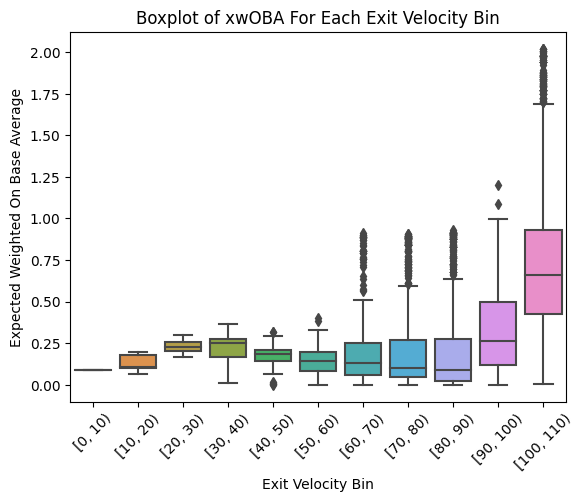

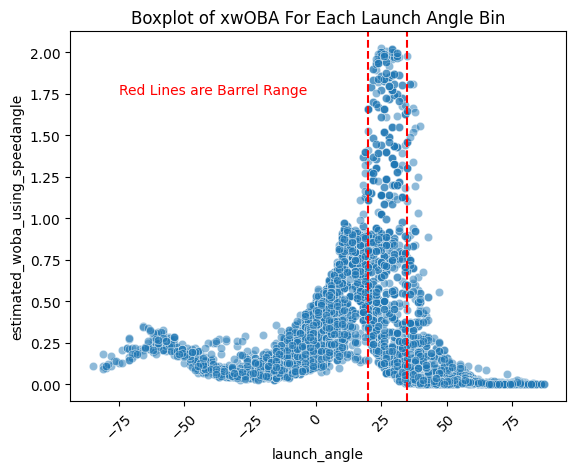

In [5]:
# subset a smaller amount of data
# 10k rows, launch speed 0-120
df_plt = (df.loc[(df['launch_speed'] >= 0)
        & (df['launch_speed'] <= 120),
         ['launch_speed', 'estimated_woba_using_speedangle', 'launch_angle']]
          .sample(10000, replace=True))


# plot the "xwOBA" based on exit velo
df_plt['launch_speed_bin'] = pd.cut(df_plt['launch_speed'],
                                    bins=range(0, 120, 10),
                                    right=False)
sns.boxplot(data=df_plt,
            x='launch_speed_bin',
            y='estimated_woba_using_speedangle')

plt.title('Boxplot of xwOBA For Each Exit Velocity Bin')
plt.xlabel("Exit Velocity Bin")
plt.ylabel('Expected Weighted On Base Average')
plt.xticks(rotation = 45)
plt.show()

# plot for "groundballs" based on launch angle
sns.scatterplot(data=df_plt, x='launch_angle',
                y='estimated_woba_using_speedangle',
                alpha=0.5)

plt.axvline(x=20, color='red', linestyle='--', label='x=24')
plt.axvline(x=35, color='red', linestyle='--', label='x=33')

plt.title('Boxplot of xwOBA For Each Launch Angle Bin')
plt.text(-75, 1.75, "Red Lines are Barrel Range", color='red')
plt.xticks(rotation = 45)
plt.show()


Through exploratory data analysis, we can discern that the characteristics of batted balls, specifically exit velocity and launch angle, are indicative of the potential success or failure of a batted ball.

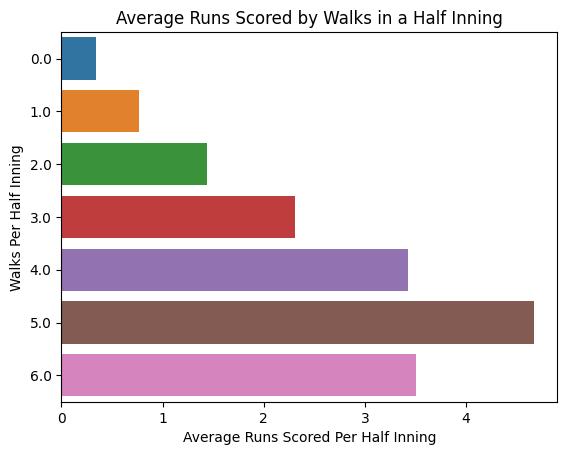

In [6]:
# Filter for walks
walk_events = df[df['events'] == 'walk']
df['runs_scored'] = df['post_bat_score'] - df['bat_score']

# Group by game, inning, and inning_topbot to count walks from walk_events
inning_walks = walk_events.groupby(['game_pk', 'inning', 'inning_topbot']).size().reset_index(name='walks')

# Group by game, inning, and inning_topbot to sum runs scored from df
inning_runs = df.groupby(['game_pk', 'inning', 'inning_topbot'])['runs_scored'].sum().reset_index()

# Merge the two dataframes on game, inning, and inning_topbot
inning_data = pd.merge(inning_walks, inning_runs, on=['game_pk', 'inning', 'inning_topbot'], how='outer').fillna(0)

grouped_data = inning_data.groupby('walks')['runs_scored'].mean().reset_index()

sns.barplot(data=grouped_data,
            x="runs_scored",
            y="walks",
            orient = 'h')

plt.title('Average Runs Scored by Walks in a Half Inning')
plt.xlabel("Average Runs Scored Per Half Inning")
plt.ylabel('Walks Per Half Inning')
plt.show()

Not only are batted balls crucial to understanding pitcher effectiveness, but walks are equally important. It is generally accepted that walks can often lead to extended innings with more runs scored; this analysis aims to provide a quantifiable approach to emphasizing the importance of limiting walks.

In [7]:
df['is_pref_launch'] = 0
df['is_whiff'] = 0
df['is_weak'] = 0
df['is_k'] = 0
df['is_bb'] = 0
whiff_events = ['swinging_strike', 'swinging_strike_blocked', 'missed_bunt']
strikeout_events = ['strikeout', 'strikeout_double_play']


df.loc[df['description'].isin(whiff_events), 'is_whiff'] = 1
df.loc[(df['launch_angle'] < 10) | (df['launch_angle'] > 45), 'is_pref_launch'] = 1
df.loc[df['launch_speed'] < 85, 'is_weak'] = 1
df.loc[df['events'] == 'walk', 'is_bb'] = 1
df.loc[df['events'].isin(strikeout_events), 'is_k'] = 1

df['events'].unique()

array(['strikeout', nan, 'force_out', 'single', 'field_out', 'walk',
       'home_run', 'hit_by_pitch', 'grounded_into_double_play', 'double',
       'sac_bunt', 'strikeout_double_play', 'fielders_choice_out',
       'fielders_choice', 'sac_fly', 'other_out', 'field_error',
       'double_play', 'triple', 'caught_stealing_2b',
       'sac_fly_double_play', 'pickoff_3b', 'caught_stealing_3b',
       'catcher_interf', 'stolen_base_3b', 'pickoff_2b', 'pickoff_1b',
       'triple_play', 'pickoff_error_3b', 'pickoff_caught_stealing_2b',
       'caught_stealing_home', 'wild_pitch',
       'pickoff_caught_stealing_home', 'stolen_base_2b'], dtype=object)

In [8]:
# Step 1: Create _df to count the number of pitches per player
dfc = df['player_name'].value_counts().reset_index()
dfc.columns = ['player_name', 'pitches']

# Step 2: Create wdf to calculate the mean of 'is_whiff' for each player
wdf = df.groupby('player_name')['is_whiff'].mean().reset_index()

# Step 3: Create df2 to calculate the mean of several columns, but only for rows where 'events' is not NaN
df2 = (
    df.loc[pd.notna(df['events']),
           ['player_name', 'is_weak', 'is_pref_launch', 'is_k', 'is_bb']]
    .groupby('player_name', as_index=False)
    .mean()
)

# Step 4: Merge all the DataFrames on 'player_name'
df2 = df2.merge(dfc, on='player_name')
df2 = df2.merge(wdf, on='player_name')
df2



,player_name,is_weak,is_pref_launch,is_k,is_bb,pitches,is_whiff
0,"Abad, Fernando",0.244898,0.285714,0.102041,0.081633,189,0.047619
1,"Abbott, Andrew",0.178571,0.302198,0.269231,0.093407,1505,0.108970
2,"Abbott, Cory",0.180451,0.375940,0.187970,0.127820,526,0.106464
3,"Abel, Mick",0.000000,0.000000,0.285714,0.142857,14,0.428571
4,"Abney, Alaska",0.000000,0.142857,0.142857,0.142857,15,0.200000
...,...,...,...,...,...,...,...
1204,"Zastryzny, Rob",0.255102,0.418367,0.193878,0.112245,379,0.126649
1205,"Zerpa, Angel",0.223301,0.446602,0.165049,0.058252,397,0.090680
1206,"Zimmermann, Bruce",0.283019,0.433962,0.226415,0.000000,187,0.160428
1207,"Zuñiga, Guillermo",0.250000,0.125000,0.500000,0.000000,43,0.069767


Listed above are the variables that appear to be most effective in evaluating relievers. As discussed earlier, the benefits of limiting exit velocity and walks, encouraging favorable launch angles, and recording whiffs and strikeouts are substantial, as they can mitigate the effects of unfavorable BABIP outcomes.

In [9]:
#Get ERA for Target
data = pitching_stats_bref(2023)

# Pull Important Variables and Find Relievers
total = data.loc[:, ['Name', 'G', 'GS', 'ERA']]
total['start_perc'] = total['GS'] / total['G']

# Create Reliever Stat
conditions = [
    (total['start_perc'] >= 0.9),
    (total['start_perc'] <= 0.70),
    (total['start_perc'] > 0.70) & (total['start_perc'] < 0.9)
]
choices = [
    'starter',
    'reliever',
    'long relief'
]

total['type'] = np.select(conditions, choices, default=np.nan)

total
rels = total.loc[:, ['Name', 'ERA', 'start_perc', 'type']]

# Make Name Joinable
rels['Name'] = rels['Name'].str.split().apply(lambda x: f'{x[1]}, {x[0]}')
rels

,Name,ERA,start_perc,type
1,"Abad, Fernando",4.26,0.000000,reliever
2,"Abbott, Andrew",3.68,1.000000,starter
3,"Abbott, Cory",6.90,0.000000,reliever
4,"Abreu, Albert",4.73,0.000000,reliever
5,"Abreu, Bryan",1.87,0.000000,reliever
...,...,...,...,...
875,"Zastryzny, Rob",4.79,0.047619,reliever
876,"Zavala, Seby",0.00,0.000000,reliever
877,"Zerpa, Angel",4.82,0.230769,reliever
878,"Zimmermann, Bruce",5.56,0.000000,reliever


In [10]:
# Join all variables together
df2 = df2.merge(rels, left_on='player_name', right_on='Name')
df2 = df2.drop(columns='Name')
df2

,player_name,is_weak,is_pref_launch,is_k,is_bb,pitches,is_whiff,ERA,start_perc,type
0,"Abad, Fernando",0.244898,0.285714,0.102041,0.081633,189,0.047619,4.26,0.000000,reliever
1,"Abbott, Andrew",0.178571,0.302198,0.269231,0.093407,1505,0.108970,3.68,1.000000,starter
2,"Abbott, Cory",0.180451,0.375940,0.187970,0.127820,526,0.106464,6.90,0.000000,reliever
3,"Abreu, Albert",0.219424,0.352518,0.212230,0.122302,1109,0.096483,4.73,0.000000,reliever
4,"Abreu, Bryan",0.160784,0.286275,0.341176,0.109804,1082,0.162662,1.87,0.000000,reliever
...,...,...,...,...,...,...,...,...,...,...
739,"Young, Danny",0.225000,0.300000,0.275000,0.050000,141,0.099291,1.08,0.000000,reliever
740,"Zastryzny, Rob",0.255102,0.418367,0.193878,0.112245,379,0.126649,4.79,0.047619,reliever
741,"Zerpa, Angel",0.223301,0.446602,0.165049,0.058252,397,0.090680,4.82,0.230769,reliever
742,"Zimmermann, Bruce",0.283019,0.433962,0.226415,0.000000,187,0.160428,5.56,0.000000,reliever


In [11]:
# Require minimum pitch count and drop any values that are null
df2 = df2.loc[df2['pitches']>= 250].dropna()

In [18]:
#Set seed for total reproductability
SEED = 1

# Set the seed for numpy
np.random.seed(SEED)

# define the features (weak, pref_launch, k%, bb%, whiff%) and the target variable (ERA)
features = ['is_weak', 'is_pref_launch', 'is_k', 'is_bb', 'is_whiff']
target = 'ERA'

# Split your data into starter and reliever datasets
starter_data = df2[df2['type'] == 'starter']
reliever_data = df2[df2['type'] == 'reliever']

# Initialize K-Fold cross-validation
kf = KFold(5, shuffle=True, random_state=1)

# Create an empty list to store the Mean Squared Errors from each fold
mse_list = []

# Create an empty series to store all out-of-sample predictions
oos_preds = pd.Series(dtype=float)

for train_index, test_index in kf.split(starter_data):

    # Split the starter data into training and validation sets
    train, validation = starter_data.iloc[train_index], starter_data.iloc[test_index]

    # Train a Random Forest Regressor on the training data
    model = RandomForestRegressor(random_state=1)
    model.fit(train[features], train[target])

    # Test the model on the reliever data
    predictions = model.predict(reliever_data[features])

    # Calculate the Mean Squared Error on the validation set and store it in the mse_list
    mse = mean_squared_error(validation[target], model.predict(validation[features]))
    mse_list.append(mse)

    # Store the predictions in the oos_preds series
    oos_preds = pd.concat([oos_preds, pd.Series(predictions, index=reliever_data.index)])

# Print the Mean Squared Errors from each fold
print(f"Mean Squared Errors from each fold: {mse_list}")

# Print the average Mean Squared Error across all folds
print(f"Average Mean Squared Error: {sum(mse_list) / len(mse_list)}")

reliever_data[f"{target}_pred"] = predictions


Mean Squared Errors from each fold: [1.5817101630000026, 0.8413525451724136, 1.3473624582758625, 1.7075842858620705, 2.0331973924137943]
Average Mean Squared Error: 1.5022413689448286


<ipython-input-18-ad3e59e2fbac>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reliever_data[f"{target}_pred"] = predictions


Text(0.5, 1.0, '\nR2: 0.323\nRMSE: 1.453\n')

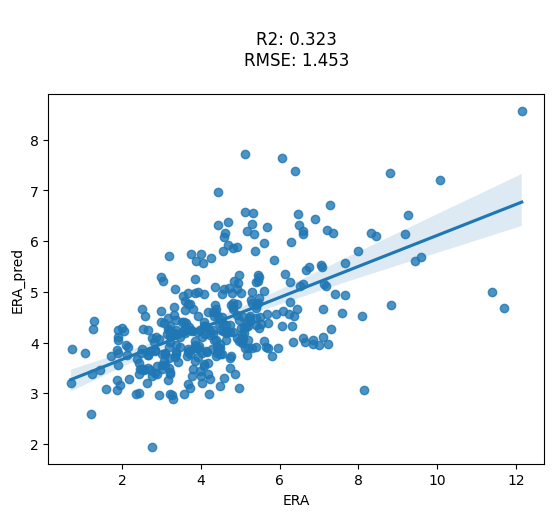

In [19]:
# apply statistics
r2 = pearsonr(reliever_data[target], reliever_data[f"{target}_pred"])[0]**2
rmse = mean_squared_error(reliever_data[target], reliever_data[f"{target}_pred"])**0.5

# visualize
title_text = f'''
R2: {round(r2, 3)}
RMSE: {round(rmse, 3)}
'''
sns.regplot(data = reliever_data, x = target, y = f"{target}_pred")
plt.title(title_text)


From the graph, it is evident that the model accurately predicts approximately 32% of the variance in the predictive ERA measure. The RMSE value of around 1.5 provides insight into the magnitude of the errors the model incurs during predictions. It appears that the model generally forecasts a higher predictive ERA compared to the players' actual ERA. This trend is logical considering that starting pitchers are often tasked with throwing more innings, thereby facing a higher probability of allowing more runs. In contrast, relievers entering late in a game do not have this margin for error; they must maintain a high level of effectiveness to avoid being pulled from the game.

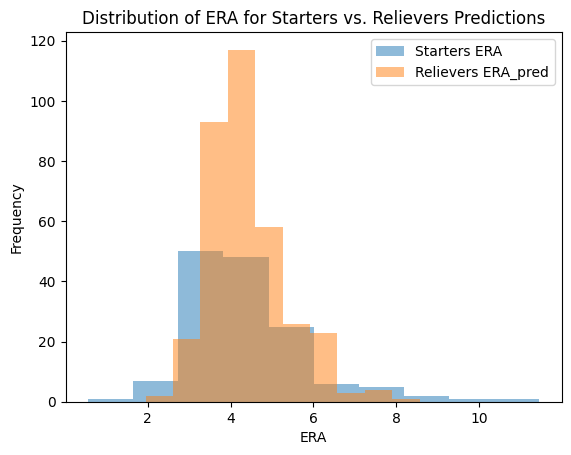

Summary for Starters' ERA:
count    146.000000
mean       4.434315
std        1.489495
min        0.560000
25%        3.562500
50%        4.180000
75%        4.967500
max       11.450000
Name: ERA, dtype: float64

Summary for Relievers' ERA Predictions:
count    348.000000
mean       4.429741
std        0.949519
min        1.944900
25%        3.812200
50%        4.246350
75%        4.829050
max        8.567100
Name: ERA_pred, dtype: float64


In [25]:
import matplotlib.pyplot as plt

plt.hist(starter_data['ERA'], alpha=0.5, label='Starters ERA')
plt.hist(reliever_data['ERA_pred'], alpha=0.5, label='Relievers ERA_pred')
plt.legend(loc='upper right')
plt.title('Distribution of ERA for Starters vs. Relievers Predictions')
plt.xlabel('ERA')
plt.ylabel('Frequency')
plt.show()

print("Summary for Starters' ERA:")
print(starter_data['ERA'].describe())

print("\nSummary for Relievers' ERA Predictions:")
print(reliever_data['ERA_pred'].describe())

From this visualization we can see that the ERA for relievers is more standardized in terms of starters ERA. The goal of the project was to make these similiar as it is more commonly known how to apply ERA to starters versus relievers.

In [26]:
(reliever_data.loc[:,
 ['player_name','pitches' ,'is_weak', 'is_pref_launch', 'is_k', 'is_bb', 'is_whiff', 'ERA', 'ERA_pred']]
 .sort_values('ERA', ascending = True).head(20))

,player_name,pitches,is_weak,is_pref_launch,is_k,is_bb,is_whiff,ERA,ERA_pred
625,"Stewart, Brock",425,0.201835,0.266055,0.357798,0.082569,0.214118,0.70,3.2126
26,"Armstrong, Shawn",587,0.241830,0.359477,0.287582,0.052288,0.129472,0.74,3.8783
409,"Martin, Chris",654,0.353846,0.384615,0.230769,0.030769,0.119266,1.07,3.7962
252,"Hader, Josh",880,0.157635,0.236453,0.384236,0.123153,0.169318,1.21,2.5896
419,"Mayza, Tim",735,0.291005,0.481481,0.232804,0.058201,0.093878,1.24,3.3799
241,"Graterol, Brusdar",840,0.271186,0.512712,0.177966,0.046610,0.070238,1.26,4.2645
662,"Uribe, Abner",318,0.178571,0.369048,0.273810,0.130952,0.125786,1.29,4.4359
122,"Chavez, Jesse",510,0.230159,0.317460,0.309524,0.079365,0.129412,1.44,3.4703
712,"Williams, Devin",836,0.220096,0.277512,0.368421,0.114833,0.188995,1.59,3.0820
208,"Francis, Bowden",557,0.170068,0.401361,0.258503,0.061224,0.111311,1.73,3.7338


In conclusion, while the current model offers valuable insights, there is room for improvement for future iterations, potentially through the incorporation of additional feature variables such as CSW% and leverage index. Hopefully, for the time being, it can shed more light on the nuanced ways relievers are utilized in conjunction with starters, facilitating more grounded comparisons of their effectiveness based on controllable factors.

Feel free to reach out with any questions, comments, or concerns via my Twitter account, where you can also find other analyses and insights. Thank you for reading.

https://twitter.com/AnalyticsMLB_